# Notebook Xử lý & Tự động Dán nhãn Hàng loạt

Mục tiêu của notebook này là chạy qua toàn bộ video trong một thư mục, trích xuất keypoint, và tự động dán nhãn cho từng frame dựa trên các luật (rule-based) về rep.

**Quy trình:**
1.  Chỉ định `VIDEO_FOLDER` (thư mục chứa video).
2.  Chạy ô "Xử lý Hàng loạt".
3.  Chương trình sẽ chạy ở chế độ "headless" (không hiển thị video, không tạm dừng) và tạo 2 file:
    * `output/all_reps_summary.csv`: Tóm tắt từng rep, gán nhãn "correct"/"incorrect".
    * `output/all_landmarks_labeled.csv`: File dữ liệu thô cho từng frame, được bổ sung cột `rep_id` và `label`.

**Cài đặt:**
Nếu bạn chưa có các thư viện, hãy chạy ô code bên dưới (bỏ comment).

In [22]:
import cv2
import mediapipe as mp
import numpy as np
import math
import csv
import time
import os
import glob
from tqdm.notebook import tqdm # Thanh tiến trình
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Các landmark quan trọng

In [23]:
# Khởi tạo giải pháp MediaPipe
mp_pose = mp.solutions.pose

def calculate_angle(a, b, c):
    """(Đã sửa) Tính góc (0-180 độ) với b là đỉnh."""
    try:
        ang_rad = math.atan2(c['py'] - b['py'], c['px'] - b['px']) - \
                    math.atan2(a['py'] - b['py'], a['px'] - b['px'])
        ang_deg = math.degrees(ang_rad)
        ang_deg = ang_deg % 360
        if ang_deg > 180:
            ang_deg = 360 - ang_deg
        return abs(ang_deg)
    except:
        return 0

def calculate_distance(a, b):
    """Tính khoảng cách Euclidean 2D giữa 2 điểm."""
    try:
        return math.sqrt((a['px'] - b['px'])**2 + (a['py'] - b['py'])**2)
    except:
        return 0

def get_view(landmarks):
    """Xác định góc nhìn của camera dựa trên tọa độ Z của vai."""
    try:
        l_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
        r_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
    except:
        return "Unknown"

    l_vis, r_vis = l_shoulder['vis'], r_shoulder['vis']
    l_z, r_z = l_shoulder['z'], r_shoulder['z']
    vis_thresh = 0.7
    z_diff = l_z - r_z
    front_thresh = 0.08
    diag_thresh = 0.25
    view = "Unknown"

    if l_vis > vis_thresh and r_vis > vis_thresh:
        if abs(z_diff) < front_thresh:
            view = "Front"
        elif z_diff > diag_thresh:
            view = "Left"
        elif z_diff < -diag_thresh:
            view = "Right"
        elif z_diff > front_thresh:
            view = "Diagonal Left"
        elif z_diff < -front_thresh:
            view = "Diagonal Right"
    elif l_vis > vis_thresh:
        view = "Right"
    elif r_vis > vis_thresh:
        view = "Left"
        
    return view

In [24]:
def analyze_video_frames(pose_detector, video_path, csv_writer, video_id):
    """
    Xử lý một file video và GHI vào đối tượng csv_writer đã được cung cấp.
    Thêm video_id và rep_id vào mỗi hàng.
    Trả về danh sách các nhãn (['Correct', 'Incorrect', ...]) của các rep đã hoàn thành.
    """
    
    cap = cv2.VideoCapture(video_path) 
    if not cap.isOpened():
        print(f"Error: Khong mo duoc video tai '{video_path}'")
        return []

    TARGET_WIDTH = 1200 
    
    # Biến trạng thái
    frame_id = 0
    rep_id_counter = 0 # (Sẽ là rep_id)
    state = "down"
    view = "Initializing"
    
    # Biến logic chấm điểm rep
    current_rep_frames = 0
    current_rep_error_frames = 0
    rep_label = "N/A"
    rep_data_log = [] # Bộ đệm
    
    completed_rep_labels = [] # Danh sách nhãn để trả về

    # Biến heuristic
    last_frame_time = time.time()
    last_wrist_pos = {'left': None, 'right': None}

    # === VÒNG LẶP XỬ LÝ VIDEO ===
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            break
        frame_id += 1

        # Resize (vẫn cần thiết cho heuristic)
        h, w = image.shape[:2]
        scale = TARGET_WIDTH / w
        dim = (TARGET_WIDTH, int(h * scale))
        image_resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        h, w = image_resized.shape[:2]

        # Xử lý MediaPipe
        # SỬA LỖI Ở DÒNG TIẾP THEO:
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB) # Sửa từ COLOR_BGR_RGB
        results = pose_detector.process(image_rgb)

        is_error_frame = False
        lm_coords = {}
        # Dữ liệu thô cho CSV (chưa có ID)
        lm_data_row_base = [frame_id]
        avg_shoulder_angle = 0

        # Trích xuất Keypoints
        if results.pose_landmarks:
            landmarks_raw = results.pose_landmarks.landmark
            
            for id, lm in enumerate(landmarks_raw):
                cx, cy = int(lm.x * w), int(lm.y * h)
                lm_coords[id] = {'x': lm.x, 'y': lm.y, 'z': lm.z, 'vis': lm.visibility, 'px': cx, 'py': cy}
                lm_data_row_base.extend([lm.x, lm.y, lm.z, lm.visibility])

            view = get_view(lm_coords)
            try:
                left_shoulder_angle = calculate_angle(lm_coords[13], lm_coords[11], lm_coords[23])
                right_shoulder_angle = calculate_angle(lm_coords[14], lm_coords[12], lm_coords[24])
                avg_shoulder_angle = (left_shoulder_angle + right_shoulder_angle) / 2
            except: pass

            # === Đếm Rep (Logic down -> up -> down) ===
            try:
                up_threshold, down_threshold = 75, 30
                new_state = state
                if avg_shoulder_angle > up_threshold: new_state = "up"
                elif avg_shoulder_angle < down_threshold: new_state = "down"
                
                # Bắt đầu rep
                if new_state == "up" and state == "down":
                    rep_id_counter += 1 # TĂNG REP_ID
                    rep_label = "In Progress"
                    rep_data_log, current_rep_frames, current_rep_error_frames = [], 0, 0
                
                # Kết thúc rep
                elif new_state == "down" and state == "up":
                    rep_label = f"Rep {rep_id_counter} Done"
                    
                    if current_rep_frames > 0 and rep_data_log:
                        current_rep_frames += 1
                        if is_error_frame: current_rep_error_frames += 1
                        rep_data_log.append(lm_data_row_base)
                        
                        error_ratio = current_rep_error_frames / current_rep_frames
                        final_label = "Incorrect" if error_ratio > 0.20 else "Correct"
                        completed_rep_labels.append(final_label) # Thêm nhãn để vẽ biểu đồ
                        
                        # GHI VÀO CSV
                        for frame_data in rep_data_log:
                            # Thêm cột ID: [video_id, rep_id, frame_id, ..., label]
                            row_to_write = [video_id, rep_id_counter] + frame_data + [final_label]
                            csv_writer.writerow(row_to_write)
                            
                    rep_data_log = []

                state = new_state
            except: pass

            # === Heuristics kiểm tra lỗi ===
            if rep_label == "In Progress":
                # Lỗi 1: Lưng thẳng
                if view != "Front":
                    try:
                        side_idx, ear_idx, shoulder_idx = (23, 7, 11) if "Left" in view else (24, 8, 12)
                        back_angle = calculate_angle(lm_coords[ear_idx], lm_coords[shoulder_idx], lm_coords[side_idx])
                        if back_angle < 165: is_error_frame = True
                    except: pass
                # Lỗi 2: Tay quá cao
                if avg_shoulder_angle > 115: is_error_frame = True
                # Lỗi 3: Nhún vai
                try:
                    l_dist = abs(lm_coords[7]['py'] - lm_coords[11]['py'])
                    r_dist = abs(lm_coords[8]['py'] - lm_coords[12]['py'])
                    shoulder_width = calculate_distance(lm_coords[11], lm_coords[12])
                    if shoulder_width > 0:
                        shrug_ratio = (l_dist + r_dist) / (2 * shoulder_width)
                        if shrug_ratio < 0.15: is_error_frame = True
                except: pass
                # Lỗi 4: Vung tay quá nhanh
                try:
                    current_time = time.time()
                    delta_time = current_time - last_frame_time
                    if delta_time > 0.01 and last_wrist_pos['left']:
                        l_vel = calculate_distance(lm_coords[15], last_wrist_pos['left']) / delta_time
                        r_vel = calculate_distance(lm_coords[14], last_wrist_pos['right']) / delta_time
                        if l_vel > 2000 or r_vel > 2000: is_error_frame = True
                    last_wrist_pos['left'], last_wrist_pos['right'] = lm_coords[15], lm_coords[14]
                    last_frame_time = current_time
                except: pass
            
            # === Ghi Log (vào bộ đệm) ===
            if rep_label == "In Progress":
                current_rep_frames += 1
                if is_error_frame:
                    current_rep_error_frames += 1
                rep_data_log.append(lm_data_row_base)
                
    # === DỌN DẸP ===
    if rep_data_log: # Xử lý rep dở dang
        final_label = "Incorrect"
        completed_rep_labels.append(final_label) # Thêm nhãn dở
        for frame_data in rep_data_log:
            row_to_write = [video_id, rep_id_counter] + frame_data + [final_label]
            csv_writer.writerow(row_to_write)
            
    cap.release()
    return completed_rep_labels

In [25]:
# === 1. ĐỊNH NGHĨA ĐƯỜNG DẪN ===
VIDEO_FOLDER = '../data/lateral raise' 
OUTPUT_DIR = 'output'
SUMMARY_CSV_NAME = 'summary_lateral_raise.csv'
SUMMARY_CSV_PATH = os.path.join(OUTPUT_DIR, SUMMARY_CSV_NAME)

# === 2. TẠO THƯ MỤC OUTPUT ===
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Đã tạo/xác nhận thư mục output tại: {os.path.abspath(OUTPUT_DIR)}")

# === 3. TÌM TẤT CẢ VIDEO ===
video_extensions = ["*.mp4", "*.avi", "*.mov", "*.mkv"]
video_files = []
for ext in video_extensions:
    video_files.extend(glob.glob(os.path.join(VIDEO_FOLDER, ext)))
print(f"Tìm thấy tổng cộng {len(video_files)} video.")

# === 4. KHỞI TẠO MEDIAPIPE (1 LẦN) ===
pose_detector = mp_pose.Pose(min_detection_confidence=0.5, 
                             min_tracking_confidence=0.5,
                             model_complexity=1)

# === 5. XỬ LÝ HÀNG LOẠT (GHI VÀO 1 FILE) ===

# Tạo header cho file CSV tổng
landmarks_header = []
for i in range(33):
    landmarks_header.extend([f'lm_{i}_x', f'lm_{i}_y', f'lm_{i}_z', f'lm_{i}_vis'])
# Thêm các cột ID mới và cột nhãn
csv_header = ['video_id', 'rep_id', 'frame_id'] + landmarks_header + ['rep_label']

# List để lưu tất cả nhãn của các rep (dùng để vẽ biểu đồ)
all_rep_labels = []

if not video_files:
    print(f"CẢNH BÁO: Không tìm thấy video nào trong '{VIDEO_FOLDER}'.")
else:
    # Mở file CSV TỔNG HỢP (chỉ 1 lần)
    with open(SUMMARY_CSV_PATH, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(csv_header) # Viết header 1 lần duy nhất
        
        print(f"Đang ghi vào file summary: {SUMMARY_CSV_PATH}")
        
        # Dùng tqdm để tạo thanh tiến trình
        for video_path in tqdm(video_files, desc="Đang xử lý các video"):
            
            # Dùng tên file (không có đuôi) làm video_id
            video_id = os.path.splitext(os.path.basename(video_path))[0]
            
            # print(f"\n[BẮT ĐẦU] Xử lý: {video_id}")
            
            # Gọi hàm xử lý, truyền csv_writer và video_id
            start_time = time.time()
            labels_from_this_video = analyze_video_frames(
                pose_detector, video_path, csv_writer, video_id
            )
            all_rep_labels.extend(labels_from_this_video)
            end_time = time.time()
            
            # print(f"[HOÀN THÀNH] {video_id} trong {end_time - start_time:.2f} giây")

# === 6. DỌN DẸP MODEL ===
pose_detector.close()
print(f"\n--- Xử lý hàng loạt hoàn tất! ---")
print(f"Tổng số {len(all_rep_labels)} rep đã được xử lý và ghi vào file summary.")

Đã tạo/xác nhận thư mục output tại: e:\Learning\Collage\2026\hocki1\pbl6\notebooks\output
Tìm thấy tổng cộng 51 video.
Đang ghi vào file summary: output\summary_lateral_raise.csv


Đang xử lý các video:   0%|          | 0/51 [00:00<?, ?it/s]


--- Xử lý hàng loạt hoàn tất! ---
Tổng số 160 rep đã được xử lý và ghi vào file summary.


Đọc file summary từ: output\summary_lateral_raise.csv

Thống kê số lượng FRAME:
rep_label
Incorrect    4663
Correct      2211
Name: count, dtype: int64


C:\Users\PC\AppData\Local\Temp\ipykernel_21816\1537328995.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


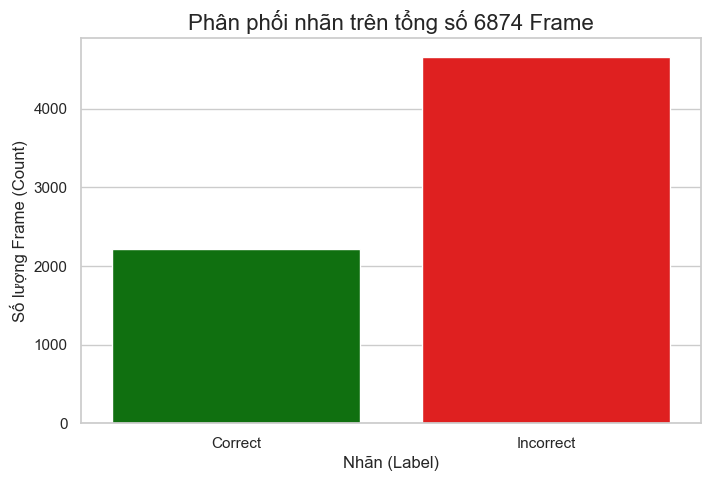

: 

In [ ]:
print(f"Đọc file summary từ: {SUMMARY_CSV_PATH}")

try:
    # Đọc file CSV tổng hợp vừa được tạo
    df_summary = pd.read_csv(SUMMARY_CSV_PATH)

    if df_summary.empty:
        print("File summary rỗng. Không có dữ liệu để vẽ biểu đồ.")
    elif 'rep_label' not in df_summary.columns:
        print("Lỗi: Không tìm thấy cột 'rep_label' trong file summary.")
    else:
        # In ra số lượng cụ thể
        print("\nThống kê số lượng FRAME:")
        print(df_summary['rep_label'].value_counts())
        
        total_frames = len(df_summary)

        # Thiết lập style cho biểu đồ
        sns.set_theme(style="whitegrid")

        # Vẽ biểu đồ
        plt.figure(figsize=(8, 5))
        ax = sns.countplot(
            data=df_summary, 
            x='rep_label', 
            order=['Correct', 'Incorrect'], # Đảm bảo thứ tự
            palette={'Correct': 'green', 'Incorrect': 'red'}
        )

        # Thêm tiêu đề và nhãn (đã cập nhật)
        ax.set_title(f'Phân phối nhãn trên tổng số {total_frames} Frame', fontsize=16)
        ax.set_xlabel('Nhãn (Label)', fontsize=12)
        ax.set_ylabel('Số lượng Frame (Count)', fontsize=12) # Đã thay đổi

        # Hiển thị biểu đồ
        plt.show()

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file summary tại '{SUMMARY_CSV_PATH}'.")
    print("Vui lòng chạy Cell 4 để tạo file trước.")
except Exception as e:
    print(f"Đã xảy ra lỗi khi đọc hoặc vẽ biểu đồ: {e}")